<a href="https://colab.research.google.com/github/MANUPRIYASINGH/MSWC_FSCIL_Reproduction/blob/main/M5_ANN_Reproduction_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MSWC FSCIL NeuroBench Tutorial

This tutorial aims to provide an insight on the MSWC FSCIL NeuroBench task and present how you can use the corresponding NeuroBench harness to benchmark your own models and solutions! In particular we give a tutorial to implement the prototypical network approach to both a convolutional and a recurrent spiking network.

## Introduction

### About FSCIL (Few-Shot Class-Incremental Learning)

Learning new tasks from a small amount of experiences while retaining knowledge of prior tasks is a hallmark of biological intelligence and a long-standing goal of general AI. It is especially a key challenge to endow edge devices with the ability to adapt to their environments and users. This benchmark thus evaluates the capacity of a learning solution to successively incorporate new classes over multiple sessions (class-incremental), with only a handful of samples from the new classes to train with (few-shot). The FSCIL task is a recently established benchmark in the computer vision domain (https://arxiv.org/abs/2004.10956), but it has not yet been adapted to other data modalities.

### The MSWC FSCIL NeuroBench Task:
Aligning with a neuromorphic interest in temporal data modalities, this benchmark introduces a FSCIL task for streaming audio keyword classification using the large Multilingual Spoken Word Corpus (MSWC) dataset (https://mlcommons.org/datasets/multilingual-spoken-words/). The task is designed to be approached in two phases: pre-training and incremental learning:
* First, for pre-training, a set of 100 words spanning 5 base languages (English, German, Catalan, French, Kinyarwanda) with 500 training samples each are made available to train an initial model. We provide here 2 pre-trained models, a convolutional and a recurrent spiking one, both trained with gradient descent on the train samples of the 100 base keywords.

* Next, for incremental learning, the model undergoes 10 successive sessions to learn words from 10 new languages (Persian, Spanish, Russian, Welsh, Italian, Basque, Polish, Esparanto, Portuguese, Dutch) in a few-shot learning scenario. Each incremental session adds 10 words of the corresponding session language with only 5 training samples available per word. Here we give a tutorial for the prototypical network solution (https://arxiv.org/abs/1703.05175), as presented in the NeuroBench paper.

## Benchmark Task

Import the modules required for running the benchmark:

In [1]:
!pip install neurobench

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Us

In [1]:
!git clone https://github.com/MANUPRIYASINGH/MSWC_FSCIL_Reproduction.git

Cloning into 'MSWC_FSCIL_Reproduction'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 77 (delta 28), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (77/77), 18.91 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [2]:
pip install git+https://github.com/V0XNIHILI/TCN-library.git

  Cloning https://github.com/V0XNIHILI/TCN-library.git to /tmp/pip-req-build-098sc089
  Running command git clone --filter=blob:none --quiet https://github.com/V0XNIHILI/TCN-library.git /tmp/pip-req-build-098sc089
  Resolved https://github.com/V0XNIHILI/TCN-library.git to commit a32c26e70cff873fb397871f7697ec56cc8d5116
  Preparing metadata (setup.py) ... done
  Created wheel for tcn-library: filename=tcn_library-0.0.1-py3-none-any.whl size=12922 sha256=ebf941531bb685b5387977644c6913d71a39185168750201c0187151a90c293f
  Stored in directory: /tmp/pip-ephem-wheel-cache-b240znpw/wheels/0c/56/1c/31842b9b5052d6df41c630521df68b0b12ddf10a0214d6766e
Successfully built tcn-library


In [3]:
cd MSWC_FSCIL_Reproduction/

/content/MSWC_FSCIL_Reproduction


In [4]:
import copy
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset

from neurobench.benchmarks import Benchmark
from neurobench.datasets import MSWC
from neurobench.datasets.MSWC_IncrementalLoader import IncrementalFewShot
from tqdm import tqdm

We fix the default settings. Redefine them to your liking:

In [5]:
# data in repo root dir
ROOT = "./data/"

NUM_WORKERS = 8
BATCH_SIZE = 256
NUM_SHOTS = 5 # How many shots to use for evaluation

Select the desired device:

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device("cuda"):
    PIN_MEMORY = True
else:
    PIN_MEMORY = False
device

device(type='cuda')

First, decide if you want to go through the tutorial with the spiking neural network (SNN) or the convolutional one (CNN). Precise this by setting `SPIKING` to True (SNN) or False (CNN).

In [7]:
SPIKING = False

#### Pre-trained model loading

We don't cover the pre-training here as it follows a standard gradient descent and can take quite some time.

The pre-training step is nevertheless significant for the FSCIL performance. The models are pre-trained on the MSWC base training subset (in code: `MSWC(root=..., subset="base", procedure="training")`) which has 100 classes with 500 samples per class. The detailed pre-training procedure can be found in the _mswc_fscil.py_ code

In [8]:
MODEL_SAVE_DIR = "./model_data/"  #Folder where pre-trained models are stored

In [9]:
from M5 import M5

We load the corresponding pre-trained model `mswc_rsnn_proto` (SNN) or `mswc_cnn_proto` (CNN) which are made available directly in the NeuroBench github repo under the `examples/mswc_fscil/model_data/` folder.

In [10]:
if SPIKING:
    model = SNN(
        input_shape=(256, 201, 20),
        neuron_type="RadLIF",
        layer_sizes=[1024, 1024, 200],
        normalization="batchnorm",
        dropout=0.1,
        bidirectional=False,
        use_readout_layer=True,
        ).to(device)

    state_dict = torch.load(os.path.join(MODEL_SAVE_DIR, "mswc_rsnn_proto"),
                        map_location=device)
    model.load_state_dict(state_dict)
else:
    model = M5(n_input=20, stride=2, n_channel=256,
            n_output=200, input_kernel=4, pool_kernel=2, drop=True).to(device)

    state_dict = torch.load(os.path.join(MODEL_SAVE_DIR, "mswc_cnn_proto"),
                        map_location=device)
    model.load_state_dict(state_dict)

We display the model below. As you can see:

- The CNN model follows the multilayer M5 architecture defined in https://arxiv.org/abs/1610.00087 with a tuned kernel size to match the employed pre-processing.
- The SNN model consists of 2 recurrent spiking neuron layers and a linear readout layer, adapted from the sparchSNN library https://github.com/idiap/sparch. The spiking neurons are leaky integrate and fire neurons with an extra adaptive variable to mitigate the impact of average activity. All neuron parameters are trained heterogeneously during pre-training.

In [11]:
model

M5(
  (conv1): Conv1d(20, 256, kernel_size=(4,), stride=(2,))
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.2, inplace=False)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=T

Then, we convert the model to a NeuroBench TorchModel to allow for computational metric benchmarking. This creates hooks to the model activity functions. The neural network itself is now stored in `model.net`.

In [12]:
from neurobench.models import TorchModel

model = TorchModel(model)

For manually defined activation modules, like the adapative LIF neuron used for the SNN model, we need to add this hook manually.

In [13]:
if SPIKING:
    model.add_activation_module(RadLIFLayer)

### Pre-processing

For the proposed solution, we employ a state-of-the-art pre-processing, namely Mel Frequency Cepstral Coefficients (MFCC) to extract relevant frequency-based coefficients. We employ the torchaudio MFCC processor (https://pytorch.org/audio/main/generated/torchaudio.transforms.MFCC.html) and tune the hop length to fix the resolution to 200Hz and the number of mel coefficients to 20 for a reasonable number of input channels to the network.

For the _spiking_ solution, a delta-encoding is added on top of MFCC to convert the signals to spikes. This is done with the Speech2Spike pipeline (https://dl.acm.org/doi/abs/10.1145/3584954.3584995) that has directly been integrated in NeuroBench. We note that this adds a spiking threshold as an extra parameter. It was fixed to 1 following the Speech2Spikes initial observations here.

In [14]:
from neurobench.preprocessing import MFCCPreProcessor, S2SPreProcessor

n_fft = 512
win_length = None
hop_length = 240
n_mels = 20
n_mfcc = 20

if SPIKING:
    encode = S2SPreProcessor(device, transpose=True)
    config_change = {"sample_rate": 48000,
                     "hop_length": 240}
    encode.configure(threshold=1.0, **config_change)
else:
    encode = MFCCPreProcessor(
        sample_rate=48000,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mels,
            "hop_length": hop_length,
            "mel_scale": "htk",
            "f_min": 20,
            "f_max": 4000,
        },
        device = device
    )

### Preparation for Prototypical Continual Learning

Before we can start using the prototypical network approach for learning incremental classes, we need to align the pre-trained model with this approach. The prototypical network approach (https://arxiv.org/abs/1703.05175) indeed relies on implementing a clustering protocol, based on the pre-trained feature extractor, as a linear readout layer; but this requires all parameters of this readout layer to be defined accordingly. Thus we first redefine the readout layer for the 100 base classes following the prototypical network approach (such that they will align with the incremental classes prototypical readout parameters).

Before continuing, we load the base training dataset that is the data available to generate the prototypical representations for the base classes. If the MSWC FSCIL dataset is not already available at `ROOT`, the entire dataset will first be downloaded from _Hugging Face_ at the following address: https://huggingface.co/datasets/NeuroBench/mswc_fscil_subset.

In [15]:
base_train_set = MSWC(root=ROOT, subset="base", procedure="training")

downloading ....


100%|██████████| 651349274/651349274 [00:26<00:00, 24421422.30it/s]


Unzipping file...


Extracting files: 100%|██████████| 90244/90244 [00:22<00:00, 3962.75file/s]


Then we create a dataloader **without shuffling** and with a batch_size of 500, which, following the definition of the dataset, will provide all samples of 1 class at each new batch.

In [16]:
train_loader = DataLoader(base_train_set, batch_size=500, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The prototypical readout parameters are defined based on the mean extracted feature $c_k$ from all training sample of the corresponding class $k$, which we get by passing all input samples through the backbone of the pre-trained network (all layers except the readout one). The prototypical weights and biases for class $k$ then are: $W_k = 2c_k, \ \ b_k=c_kc_k^T$.

To do so, we first define a new readout layer supporting 200 classes (100 base classes + 100 incrementally learned classes) that will replace the pre-trained one:

In [17]:
# Set-up new proto readout layer
if SPIKING:
    output = model.net.snn[-1].W
    proto_out = nn.Linear(output.weight.shape[1], 200, bias=True).to(device)
    proto_out.weight.data = output.weight.data
else:
    output = model.net.output
    proto_out = nn.Linear(512, 200, bias=True).to(device)
    proto_out.weight.data = output.weight.data

Then we pass through each of the base training classes, get all of the 500 associated sample feature, average them and define the weights and biases accordingly.

Just note that for the _spiking_ solution, the features are summed over time and thus the bias is also divided by the number of total timesteps.

_Note_: This procedure can take a bit of time.

In [18]:
# Compute prototype weights for base classes

for data, target in tqdm(train_loader):
    data, target = encode((data.to(device), target.to(device)))
    data = data.squeeze()
    class_id = target[0]

    if SPIKING:
        features = data
        for layer in model.net.snn[:-1]:
            features = layer(features)

        mean = torch.sum(features, dim=[0,1])/500
        proto_out.weight.data[class_id] = 2*mean
        proto_out.bias.data[class_id] = -torch.matmul(mean, mean.t())/features.shape[1]

    else:
        features = model.net(data, features_out=True)

        mean = torch.sum(features, dim=0)/500
        proto_out.weight.data[class_id] = 2*mean
        proto_out.bias.data[class_id] = -torch.matmul(mean, mean.t())

    del data
    del features
    del mean

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 100/100 [02:46<00:00,  1.66s/it]


Finally we replace the pre-trained readout layer by the newly defined prototypical one:

In [19]:

# Replace pre-trained readout with prototypical layer
if SPIKING:
    model.net.snn[-1].W = proto_out
else:
    model.net.output = proto_out

del base_train_set
del train_loader

Next, we test the performance of the prototypical representations on the base test set using a NeuroBench Benchmark:

In [20]:
# Copy model for evaluation
eval_model = copy.deepcopy(model)

# Get base test set for evaluation
base_test_set = MSWC(root=ROOT, subset="base", procedure="testing")
test_loader = DataLoader(base_test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Put the model in evaluation mode
eval_model.net.eval()

M5(
  (conv1): Conv1d(20, 256, kernel_size=(4,), stride=(2,))
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (drop1): Dropout(p=0.2, inplace=False)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (drop2): Dropout(p=0.2, inplace=False)
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(256, 512, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (drop3): Dropout(p=0.2, inplace=False)
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(512, 512, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=T

As NeuroBench Benchmarks encapsulate the whole testing, it requires some pre and post-processors to manipulate data before and aftera network pass. We thus define the following utility functions:

In [21]:
squeeze = lambda x: (x[0].squeeze(), x[1])
out2pred = lambda x: torch.argmax(x, dim=-1)
to_device = lambda x: (x[0].to(device), x[1].to(device))

We also define a mask function for this evaluation as the network is directly defined with 200 output neurons but we are for now evaluating the performance solely on the 100 base classes:

In [22]:
# Define specific post-processing with masking on the base classes
mask = torch.full((200,), float('inf')).to(device)
mask[torch.arange(0,100, dtype=int)] = 0
out_mask = lambda x: x - mask

Now we can define the Benchmark object with the desired metrics:

In [23]:
# Metrics
static_metrics = ["footprint", "connection_sparsity"]
workload_metrics = ["classification_accuracy", "activation_sparsity", "synaptic_operations"]

# Define benchmark object
benchmark_all_test = Benchmark(eval_model, metric_list=[static_metrics, workload_metrics],
                               dataloader=test_loader,
                               preprocessors=[to_device, encode, squeeze], postprocessors=[])

We now run the Benchmark on the base test set:

In [24]:
pre_train_results = benchmark_all_test.run(postprocessors=[out_mask, F.softmax, out2pred, torch.squeeze])

print("Base results:", pre_train_results)

print(f"The base accuracy is {pre_train_results['classification_accuracy']*100}%")

Running benchmark


  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/neurobench/benchmarks/benchmark.py:120: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = alg(preds)
100%|██████████| 40/40 [00:44<00:00,  1.11s/it]

Base results: {'footprint': 6028096, 'connection_sparsity': 0.0, 'classification_accuracy': 0.9471999999999999, 'activation_sparsity': 0.7841849283854165, 'synaptic_operations': {'Effective_MACs': 7810636.2784, 'Effective_ACs': 0.0, 'Dense': 25919488.0}}
The base accuracy is 94.72%


This is the performance of session 0.

Note that the obtained accuracy, after conversion to prototypes, is below the original performance of the pre-trained model. This is a price to pay to allow for the prototypical network to work effectively in the incremental sessions. This could nevertheless still be improved upon, especially for the _spiking_ solution, where the conversion accuracy drop is significant (from 93% to 84%).

### Incremental Learning

We can now pursue with the few-shot incremental sessions. New sessions are learned following the prototypical network approach on the corresponding session classes and with the limited number of samples available.

We first initialize the FSCIL dataloader. It will generate 10 sessions from a random ordering of the 10 incremental languages. Each session consists of
- One `support` _list_ of `NUM_SHOTS` shots, each shot being a tuple of tensors `(X_shot, y_shot)` with one sample for each of the 10 session classes.  
- One `query` _dataset_ with all the current and prior incremental session classes and `query_shots` samples per class.
- One `query_classes` list that contains each unique incremental class index following their order of appearance.

Note that the `support_query_split` is here to define a pre-sampling split between samples available for support and for query in this order. In the proposed set-up, the few-shot dataloader thus fixes the 100 query samples per class from the start and samples 5 shots out of a 100 samples for each incremental class:

In [25]:
# IncrementalFewShot Dataloader used in incremental mode to generate class-incremental sessions
few_shot_dataloader = IncrementalFewShot(k_shot=NUM_SHOTS,
                            root = ROOT,
                            query_shots=100,
                            support_query_split=(100,100))

We then run one incremental session learning as an example:

In [26]:
support, query, query_classes = next(iter(few_shot_dataloader))

The support data - which is generated in a shot-by-shot way for universality to different methods - is here concatenated to gather all training samples per class for the prototypical approach:

In [27]:
data = None

for X_shot, y_shot in support:
    if data is None:
        data = X_shot
        target = y_shot
    else:
        data = torch.cat((data,X_shot), 0)
        target = torch.cat((target,y_shot), 0)

data, target = encode((data.to(device), target.to(device)))
data = data.squeeze()

new_classes = y_shot.tolist()
Nways = len(y_shot) # Number of ways of one batch, should always be 10

We then apply the prototypical network approach on the corresponding incremental classes:

In [28]:
if SPIKING:
    features = eval_model.net.snn[0](data)
    features = eval_model.net.snn[1](features)

    for index, class_id in enumerate(new_classes):
        mean = torch.sum(features[[i*Nways+index for i in range(NUM_SHOTS)]], dim=[0,1])/NUM_SHOTS
        eval_model.net.snn[-1].W.weight.data[class_id] = 2*mean
        eval_model.net.snn[-1].W.bias.data[class_id] = -torch.matmul(mean, mean.t())/(features.shape[1])
else:
    features = eval_model.net(data, features_out=True)

    for index, class_id in enumerate(new_classes):
        mean = torch.sum(features[[i*Nways+index for i in range(NUM_SHOTS)]], dim=0)/NUM_SHOTS
        eval_model.net.output.weight.data[class_id] = 2*mean
        eval_model.net.output.bias.data[class_id] = -torch.matmul(mean, mean.t())

Then we evaluate the performance after one FSCIL session. The default FSCIL benchmarking evaluates accuracy on all classes seen so far, including the base classes used for pre-training. To this, we add an evaluation of the performance solely on the incremental few-shot classes, corresponding to only the `query` dataset.

Note that the dataloaders used for the benchmarking are actually redefined when running the Benchmark object. This is to be aligned with the general case of multiple sessions (see cell below) as the data to test on changes over sessions in a FSCIL task.

In [29]:
# Define benchmark object for incremental classes
benchmark_new_classes = Benchmark(eval_model, metric_list=[[],["classification_accuracy"]],
                                  dataloader=None,
                                  preprocessors=[to_device, encode, squeeze], postprocessors=[])

### Testing phase ###
eval_model.net.eval()

# Define session dataloaders for query and query + base_test samples
query_loader = DataLoader(query, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

full_session_test_set = ConcatDataset([base_test_set, query])
full_session_test_loader = DataLoader(full_session_test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Create a mask function to only consider accuracy on classes presented so far
session_classes = torch.cat((torch.arange(0,100, dtype=int), torch.IntTensor(query_classes)))
mask = torch.full((200,), float('inf')).to(device)
mask[session_classes] = 0
out_mask = lambda x: x - mask


# Run benchmark on query classes only
query_results = benchmark_new_classes.run(dataloader = query_loader,
                                          postprocessors=[out_mask, F.softmax, out2pred, torch.squeeze])
print(f"Accuracy on new classes: {query_results['classification_accuracy']*100} %")

# Run benchmark to evaluate accuracy of this specific session
session_results = benchmark_all_test.run(dataloader = full_session_test_loader,
                                         postprocessors=[out_mask, F.softmax, out2pred, torch.squeeze])
print(f"Session accuracy: {session_results['classification_accuracy']*100} %")

Running benchmark


100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Accuracy on new classes: 90.19999976158142 %
Running benchmark


100%|██████████| 43/43 [00:46<00:00,  1.09s/it]

Session accuracy: 94.16363633762707 %


Finally, we can run the full FSCIL setup by looping over the code as presented above for all 10 sessions:

_Note_: This can take a bit of time as FSCIL requires for increasingly heavy datasets to be loaded in memory.

Session: 1
Running benchmark


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


Accuracy on new classes: 80.69999923706055 %
Running benchmark


100%|██████████| 43/43 [00:59<00:00,  1.38s/it]


Session accuracy: 93.31818171414461 %
Session results: {'footprint': 6028096, 'connection_sparsity': 0.0001, 'classification_accuracy': 0.9331818171414462, 'activation_sparsity': 0.7833916833778966, 'synaptic_operations': {'Effective_MACs': 7832556.199454545, 'Effective_ACs': 0.0, 'Dense': 25919488.0}}
Session: 2
Running benchmark


100%|██████████| 8/8 [00:19<00:00,  2.44s/it]


Accuracy on new classes: 77.60000023841857 %
Running benchmark


100%|██████████| 47/47 [00:50<00:00,  1.06s/it]


Session accuracy: 91.5333334128062 %
Session results: {'footprint': 6028096, 'connection_sparsity': 0.0001, 'classification_accuracy': 0.915333334128062, 'activation_sparsity': 0.7831984687755311, 'synaptic_operations': {'Effective_MACs': 7840529.322, 'Effective_ACs': 0.0, 'Dense': 25919488.0}}
Session: 3
Running benchmark


100%|██████████| 12/12 [00:19<00:00,  1.65s/it]


Accuracy on new classes: 80.60000003178914 %
Running benchmark


100%|██████████| 51/51 [00:52<00:00,  1.04s/it]


Session accuracy: 90.42307686805725 %
Session results: {'footprint': 6028096, 'connection_sparsity': 0.0002, 'classification_accuracy': 0.9042307686805725, 'activation_sparsity': 0.7844828873256033, 'synaptic_operations': {'Effective_MACs': 7801402.892384616, 'Effective_ACs': 0.0, 'Dense': 25919488.0}}
Session: 4
Running benchmark


100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


Accuracy on new classes: 79.69999999999999 %
Running benchmark


100%|██████████| 55/55 [00:55<00:00,  1.01s/it]


Session accuracy: 89.32142858505247 %
Session results: {'footprint': 6028096, 'connection_sparsity': 0.0003, 'classification_accuracy': 0.8932142858505248, 'activation_sparsity': 0.7844771205357141, 'synaptic_operations': {'Effective_MACs': 7798129.7972142855, 'Effective_ACs': 0.0, 'Dense': 25919488.0}}
Session: 5
Running benchmark


100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Accuracy on new classes: 80.74000000953674 %
Running benchmark


100%|██████████| 59/59 [00:57<00:00,  1.02it/s]


Session accuracy: 88.96666666348776 %
Session results: {'footprint': 6028096, 'connection_sparsity': 0.0003, 'classification_accuracy': 0.8896666666348776, 'activation_sparsity': 0.7846290428410949, 'synaptic_operations': {'Effective_MACs': 7794563.261333333, 'Effective_ACs': 0.0, 'Dense': 25919488.0}}
Session: 6
Running benchmark


100%|██████████| 24/24 [00:26<00:00,  1.12s/it]


Accuracy on new classes: 80.1333333651225 %
Running benchmark


100%|██████████| 63/63 [01:02<00:00,  1.00it/s]


Session accuracy: 88.13749999999999 %
Session results: {'footprint': 6028096, 'connection_sparsity': 0.0004, 'classification_accuracy': 0.8813749999999999, 'activation_sparsity': 0.7840102993834255, 'synaptic_operations': {'Effective_MACs': 7809163.0148125, 'Effective_ACs': 0.0, 'Dense': 25919488.0}}
Session: 7
Running benchmark


100%|██████████| 28/28 [00:32<00:00,  1.18s/it]


Accuracy on new classes: 77.81428574153352 %
Running benchmark


100%|██████████| 67/67 [01:06<00:00,  1.00it/s]


Session accuracy: 86.68235297483555 %
Session results: {'footprint': 6028096, 'connection_sparsity': 0.0004, 'classification_accuracy': 0.8668235297483555, 'activation_sparsity': 0.7830912505857124, 'synaptic_operations': {'Effective_MACs': 7836221.009647059, 'Effective_ACs': 0.0, 'Dense': 25919488.0}}
Session: 8
Running benchmark


100%|██████████| 32/32 [00:35<00:00,  1.11s/it]


Accuracy on new classes: 78.24999999999997 %
Running benchmark


100%|██████████| 71/71 [01:07<00:00,  1.05it/s]


Session accuracy: 86.33333334922791 %
Session results: {'footprint': 6028096, 'connection_sparsity': 0.0004, 'classification_accuracy': 0.8633333334922791, 'activation_sparsity': 0.7832473958333332, 'synaptic_operations': {'Effective_MACs': 7834510.873888889, 'Effective_ACs': 0.0, 'Dense': 25919488.0}}
Session: 9
Running benchmark


100%|██████████| 36/36 [00:40<00:00,  1.12s/it]


Accuracy on new classes: 77.94444443914625 %
Running benchmark


100%|██████████| 75/75 [01:12<00:00,  1.04it/s]


Session accuracy: 85.73684211530183 %
Session results: {'footprint': 6028096, 'connection_sparsity': 0.0005, 'classification_accuracy': 0.8573684211530183, 'activation_sparsity': 0.7830831156475748, 'synaptic_operations': {'Effective_MACs': 7839692.255, 'Effective_ACs': 0.0, 'Dense': 25919488.0}}
Session: 10
Running benchmark


100%|██████████| 40/40 [00:42<00:00,  1.07s/it]


Accuracy on new classes: 77.97999999999999 %
Running benchmark


100%|██████████| 79/79 [01:15<00:00,  1.05it/s]


Session accuracy: 85.315 %
Session results: {'footprint': 6028096, 'connection_sparsity': 0.0005, 'classification_accuracy': 0.85315, 'activation_sparsity': 0.7828554074754902, 'synaptic_operations': {'Effective_MACs': 7845238.0178, 'Effective_ACs': 0.0, 'Dense': 25919488.0}}
Accuracy over all sessions: [93.31818171414461, 91.5333334128062, 90.42307686805725, 89.32142858505247, 88.96666666348776, 88.13749999999999, 86.68235297483555, 86.33333334922791, 85.73684211530183, 85.315]
[93.31818171414461, 91.5333334128062, 90.42307686805725, 89.32142858505247, 88.96666666348776, 88.13749999999999, 86.68235297483555, 86.33333334922791, 85.73684211530183, 85.315]


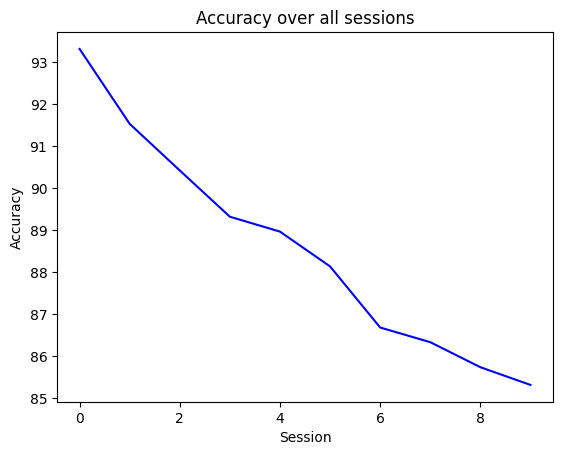

In [30]:
# variable to store accuracy
acc = []
acc_new_classes = []

# Iteration over incremental sessions
for session, (support, query, query_classes) in enumerate(few_shot_dataloader):
    print(f"Session: {session+1}")

    ### Computing new Prototypical Weights ###
    data = None

    for X_shot, y_shot in support:
        if data is None:
            data = X_shot
            target = y_shot
        else:
            data = torch.cat((data,X_shot), 0)
            target = torch.cat((target,y_shot), 0)

    data, target = encode((data.to(device), target.to(device)))
    data = data.squeeze()

    new_classes = y_shot.tolist()
    Nways = len(y_shot) # Number of ways, should always be 10

    if SPIKING:
        features = eval_model.net.snn[0](data)
        features = eval_model.net.snn[1](features)

        for index, class_id in enumerate(new_classes):
            mean = torch.sum(features[[i*Nways+index for i in range(NUM_SHOTS)]], dim=[0,1])/NUM_SHOTS
            eval_model.net.snn[-1].W.weight.data[class_id] = 2*mean
            eval_model.net.snn[-1].W.bias.data[class_id] = -torch.matmul(mean, mean.t())/(features.shape[1])
    else:
        features = eval_model.net(data, features_out=True)

        for index, class_id in enumerate(new_classes):
            mean = torch.sum(features[[i*Nways+index for i in range(NUM_SHOTS)]], dim=0)/NUM_SHOTS
            eval_model.net.output.weight.data[class_id] = 2*mean
            eval_model.net.output.bias.data[class_id] = -torch.matmul(mean, mean.t())

    ### Testing phase ###
    eval_model.net.eval()

    # Define session dataloaders for query and query + base_test samples
    query_loader = DataLoader(query, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    full_session_test_set = ConcatDataset([base_test_set, query])
    full_session_test_loader = DataLoader(full_session_test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    # Create a mask function to only consider accuracy on classes presented so far
    session_classes = torch.cat((torch.arange(0,100, dtype=int), torch.IntTensor(query_classes)))
    mask = torch.full((200,), float('inf')).to(device)
    mask[session_classes] = 0
    out_mask = lambda x: x - mask

    # Run benchmark on query classes only
    query_results = benchmark_new_classes.run(dataloader = query_loader, postprocessors=[out_mask, F.softmax, out2pred, torch.squeeze])
    print(f"Accuracy on new classes: {query_results['classification_accuracy']*100} %")

    # Run benchmark to evaluate accuracy of this specific session
    session_results = benchmark_all_test.run(dataloader = full_session_test_loader, postprocessors=[out_mask, F.softmax, out2pred, torch.squeeze])
    print(f"Session accuracy: {session_results['classification_accuracy']*100} %")
    print("Session results:", session_results)
    acc.append(session_results['classification_accuracy'] * 100)
    acc_new_classes.append(query_results['classification_accuracy'] * 100)


print(f"Accuracy over all sessions: {acc}")

print(acc)
import matplotlib.pyplot as plt
plt.plot(acc, color='blue')
# plt.plot(acc_given_data_set, color='red')
plt.ylabel('Accuracy')
plt.xlabel('Session')
plt.title('Accuracy over all sessions')

plt.show()

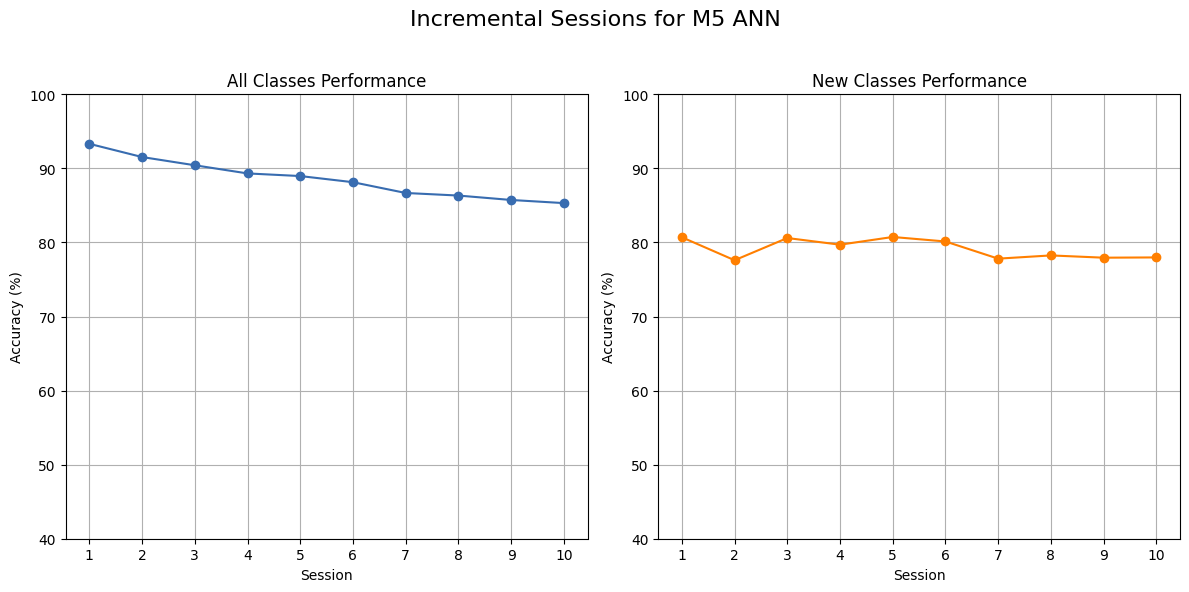

In [31]:
import matplotlib.pyplot as plt
import numpy as np

sessions = np.arange(1, 11, 1)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(sessions, acc, "-o", color="#386cb0")
axs[0].set_xticks(sessions)
axs[0].set_ylim((40, 100))
axs[0].set_ylabel('Accuracy (%)')
axs[0].set_xlabel('Session')
axs[0].set_title('All Classes Performance')
axs[0].grid(True)

axs[1].plot(sessions, acc_new_classes, "-o", color="#ff7f00")
axs[1].set_xticks(sessions)
axs[1].set_ylim((40, 100))
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_xlabel('Session')
axs[1].set_title('New Classes Performance')
axs[1].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.90])
fig.suptitle('Incremental Sessions for M5 ANN', fontsize=16)

plt.savefig("outputs/M5_ANN_performance_plots.png", dpi=300)

plt.show()


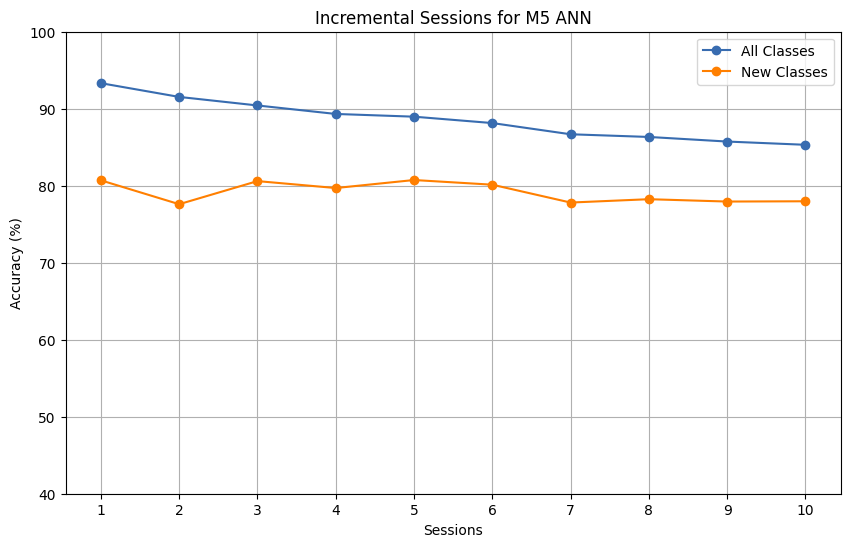

In [32]:
sessions = np.arange(1, 11, 1)

plt.figure(figsize=(10, 6))

plt.plot(sessions, acc, "-o", color="#386cb0", label='All Classes')

plt.plot(sessions, acc_new_classes, "-o", color="#ff7f00", label='New Classes')

plt.xticks(sessions)

plt.ylim((40, 100))

plt.ylabel('Accuracy (%)')
plt.xlabel('Sessions')
plt.title('Incremental Sessions for M5 ANN')

plt.grid(True)
plt.legend()
plt.savefig("outputs/M5_ANN_performance_plot2.png", dpi=300)
plt.show()

You should obtain a performance within the bounds presented in the results plot below. The shaded area represents $5^{th}$ and $95^{th}$ percentile on 100 runs.

![title](https://github.com/MANUPRIYASINGH/MSWC_FCIL_DL/blob/main/img/FSCIL_proto_results.png?raw=1)